# **CSV Analysis Tools**

# By Malek Ibrahim, 07.04.2022

The goal of this code is to develop various functions to extract data from csv files saved during training of DDPMs. Such files currently include validation loss over time, training loss over time, and DDRM PSNR on validation set mean + standard deviation.

In [ ]:
# Proprietary and Confidential
# Copyright 2003 - 2020 Stone Aerospace
# 3511 Caldwell Lane, Del Valle, TX 78617
# All rights reserved

In [ ]:
# import modules/dependencies
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from scipy import stats
plt.rcParams['figure.figsize'] = [16, 8]

In [ ]:
# if you want interactive figures
!pip install ipympl
%matplotlib ipympl

In [ ]:
# (optional) if using Google Colab, run this cell
from google.colab import drive
from google.colab import output
output.enable_custom_widget_manager()
drive.mount(f'{os.sep}content{os.sep}drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def loss_plotter(loss_data, labels, fig_num):
        """Plots loss values obtained from a model training run.
        
        Args:
            loss_data: A list of 1D numpy arrays, or paths to a file for loading
            labels: A list of str objects corresponding to the items in loss_data
            
        Returns:
            A plot of the data with all loss plots and minimum loss locations labeled.
            
        """
        # initialize figure
        plt.figure(fig_num)
        
        # loop over the list
        for i, item in enumerate(loss_data):
          # loads the file if it is a string
          if isinstance(item,str):
            data = np.array(pd.read_csv(item).iloc[:,-1])
          else:
            data = item
          
          x = np.arange(0, len(data)) + 1
          plt.plot(x, data, label=labels[i])
          
        plt.title('Loss Plot')
        plt.legend()
        plt.show()

In [ ]:
# specify the output directory which contains csv files
out_dir = f'{os.sep}content{os.sep}drive{os.sep}MyDrive{os.sep}sandbox{os.sep}models{os.sep}MBARI-Monterey-Canyon_5-m_hi-res_4337x60x60 (1c)'

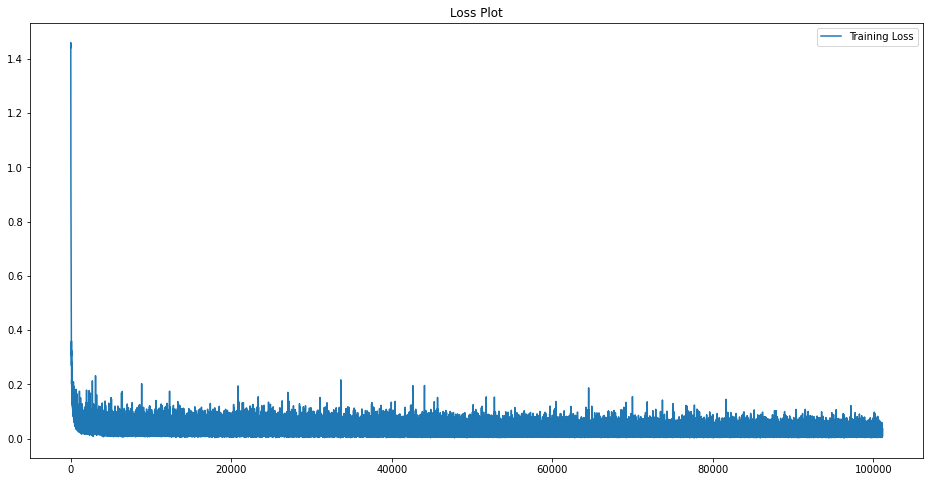

In [ ]:
# obtain training loss plot
plt.cla()
file_path = f"{out_dir}{os.sep}loss_log.csv"
loss_plotter([file_path], ['Training Loss'],1) # try semi-log plot to resolve lower tail

In [ ]:
# calculate running mean function 
def running_mean(data, window_size, window_step):
  """Computes running mean of a data array.
        
  Args:
      data: A 1D array.
      
  Returns:
      The running mean of the data input, same shape as data.
  """
  
  # initialize the running mean, iteration counter
  output = np.zeros_like(data)
  length = 0
  count = 0

  assert len(data) >= window_size, 'The window size over which the mean is computed must be smaller than the data length. Please reduce the window size and try again.'

  while len(data) - length >= window_size:
    output[window_step*count:window_step*(count+1)] = np.mean(data[window_step*count:window_size+window_step*count])
    length += window_step
    count += 1
  
  # take mean of remained of data array and set equal to remaining slice of running_mean
  output[window_step*(count-1)::] = np.mean(data[window_step*(count-1)::])

  return output

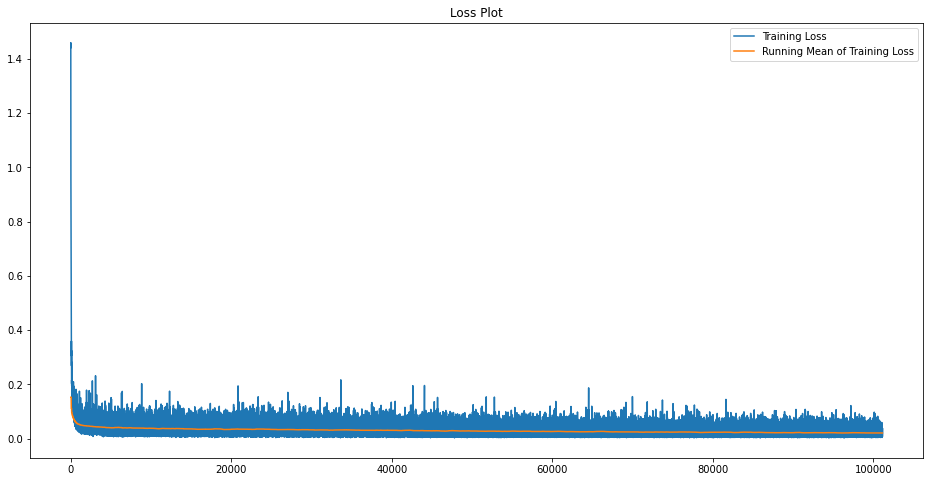

In [ ]:
# plot the training loss with the running average overlayed
file_path = f"{out_dir}{os.sep}loss_log.csv"
loss_data = np.array(pd.read_csv(file_path).iloc[:,-1])
RM = running_mean(loss_data,1000,50)
loss_plotter([file_path, RM], ['Training Loss', 'Running Mean of Training Loss'], 2)

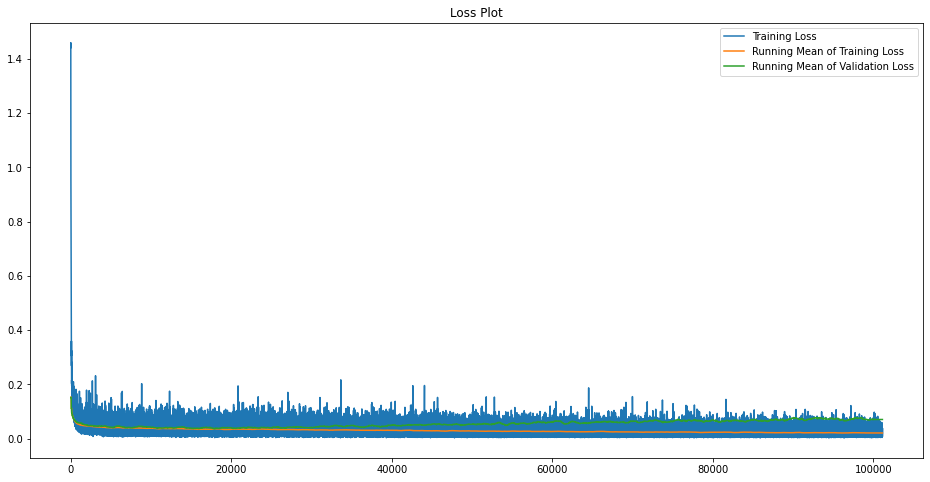

In [ ]:
# plot the training loss, validation loss, and running means overlayed on top of one another
file_path_training = f"{out_dir}{os.sep}loss_log.csv"
file_path_validation = f"{out_dir}{os.sep}val_loss_log.csv"
RM_training = running_mean(np.array(pd.read_csv(file_path_training).iloc[:,-1]),1000,50)
RM_validation = running_mean(np.array(pd.read_csv(file_path_validation).iloc[:,-1]),1000,50)

loss_plotter([file_path_training,RM_training,RM_validation], ['Training Loss', 'Running Mean of Training Loss', 'Running Mean of Validation Loss'], 3)

In [ ]:
# plot the PSNR statistics
def plot_PSNR(mean_data, std_data, fig_num):
  """Plots the mean PSNR data obtained during training along with standard deviation
        
  Args:
      mean_data: A 1D array or path to csv file, each point represents the mean PSNR calculated for a given batch of validation data
      std_data: A 1D array or path to csv file, each point represent the std of the PSNR calculated for a given batch of validation data
      fig_num: int, figure number to plot the data
      
  Returns:
      A plot of the mean and std for the PSNR data.
  """

  # if necessary, load mean and standard deviation data
  if isinstance(mean_data,str):
    mdata = np.array(pd.read_csv(mean_data).iloc[:,-1])
  else:
    mdata = mean_data

  if isinstance(std_data,str):
    sdata = np.array(pd.read_csv(std_data).iloc[:,-1])
  else:
    sdata = std_data

  # initialize the figure
  plt.figure(fig_num)

  # plot the mean data
  p = plt.plot(mdata)
  plt.fill_between(np.arange(len(mdata)), mdata-sdata, mdata+sdata, color=p[0].get_color(), alpha=0.25)

  plt.title('DDRM PSNR Over Model Training')
  plt.show()

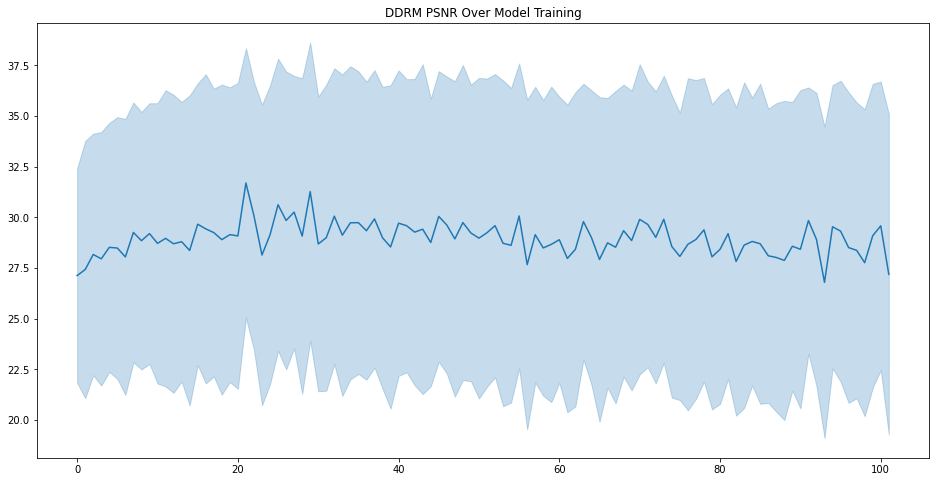

In [ ]:
# plot the PSNR data using defined function
mean_path = f'{os.sep}content{os.sep}drive{os.sep}MyDrive{os.sep}sandbox{os.sep}models{os.sep}MBARI-Monterey-Canyon_5-m_hi-res_4337x60x60 (1c){os.sep}PSNR_mean.csv'
std_path = f'{os.sep}content{os.sep}drive{os.sep}MyDrive{os.sep}sandbox{os.sep}models{os.sep}MBARI-Monterey-Canyon_5-m_hi-res_4337x60x60 (1c){os.sep}PSNR_std.csv'

plot_PSNR(mean_path,std_path,6)

In [ ]:
# plot the correlation between DDRM PSNR and validation loss
X = running_mean(np.array(pd.read_csv(file_path_validation).iloc[:,-1]),1000,1000)[2000::1000]
Y = np.array(pd.read_csv(mean_path).iloc[:,-1])[2::]
slope, intercept, r_value, p_value, std_err = stats.linregress(X,Y)

slope, intercept, r_value, p_value

(-25.177882675601445,
 30.35490569092521,
 -0.3675934730176694,
 0.00016833451276826236)

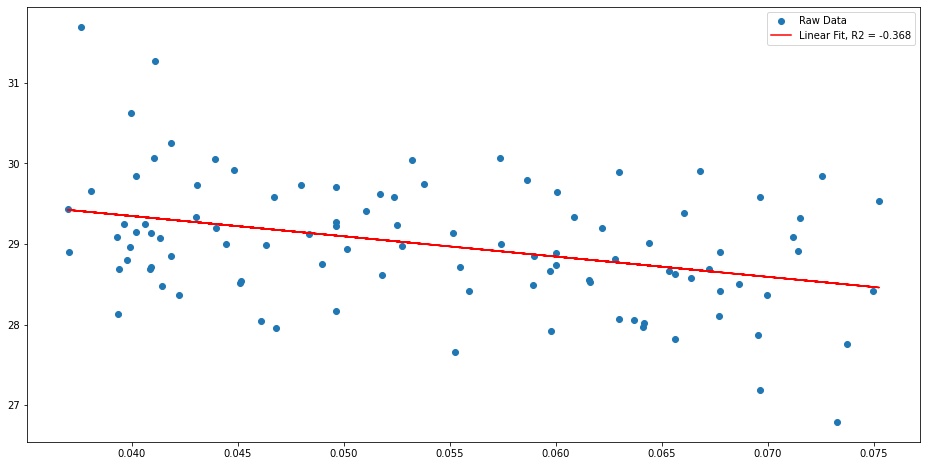

In [ ]:
plt.figure(11)
plt.scatter(X,Y,label='Raw Data')
plt.plot(X, slope*X + intercept, label=f'Linear Fit, R2 = {r_value:.03f}', color='r')
plt.legend()
plt.show()